In [4]:
# Verify GPU is available
import jax
print(f"JAX devices: {jax.devices()}")
print(f"Backend: {jax.default_backend()}")
assert jax.default_backend() == "gpu", "GPU not detected! Check your kernel configuration."


JAX devices: [CudaDevice(id=0)]
Backend: gpu


In [5]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit

import jaxley as jx
from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect, connect, sparse_connect

In [6]:
comp = jx.Compartment()
branch = jx.Branch(comp, ncomp=5)

parents = jnp.asarray([-1, 0, 0])
cell = jx.Cell(branch, parents=parents)

# cell.insert(Leak())             # everywhere
# cell.branch(0).insert(Na())     # add Na/K on “soma branch”
# cell.branch(0).insert(K())


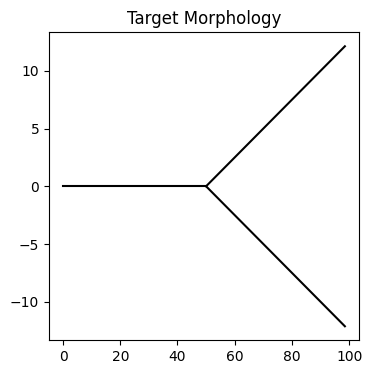

In [7]:
cell.compute_xyz()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
cell.vis(ax=ax)
ax.set_title("Target Morphology");


In [8]:
n_pre = 5
num_cells = n_pre + 1
net = jx.Network([cell for _ in range(num_cells)])

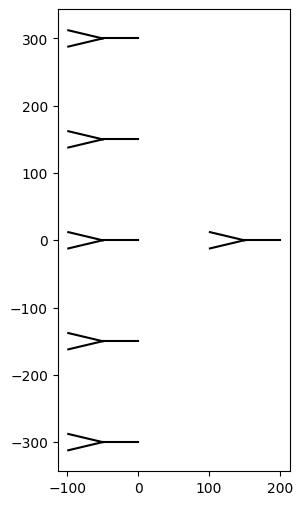

In [9]:
net.compute_xyz()
net.rotate(180)
net.arrange_in_layers(layers=[5, 1], within_layer_offset=150, between_layer_offset=200)

fig, ax = plt.subplots(1, 1, figsize=(3, 6))
_ = net.vis(ax=ax, detail="full")

In [10]:
pre = net.cell(range(n_pre))
post = net.cell(n_pre)
fully_connect(pre, post, IonotropicSynapse(),random_post_comp=False)
# net.set("IonotropicSynapse_gS", 0.0005)   # nS, tweak as needed
# sparse_connect(pre, post, IonotropicSynapse(), p=0.8, random_post_comp=True)

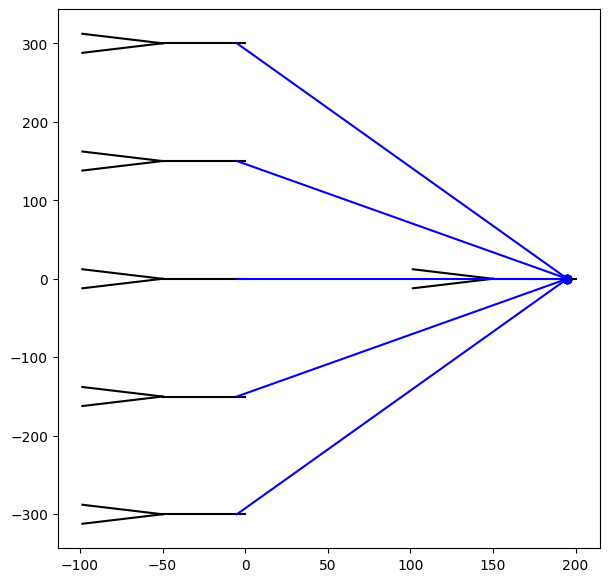

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
_ = net.vis(ax=ax, detail="full")

In [12]:
net.edges

,global_edge_index,index_within_type,pre_index,post_index,type,type_ind,pre_locs,post_locs,IonotropicSynapse_gS,IonotropicSynapse_e_syn,IonotropicSynapse_k_minus,IonotropicSynapse_v_th,IonotropicSynapse_delta,IonotropicSynapse_s,controlled_by_param
0,0,0,0,80,IonotropicSynapse,0,0.1,0.1,0.0001,0.0,0.025,-35.0,10.0,0.2,0
1,1,1,16,80,IonotropicSynapse,0,0.1,0.1,0.0001,0.0,0.025,-35.0,10.0,0.2,0
2,2,2,32,80,IonotropicSynapse,0,0.1,0.1,0.0001,0.0,0.025,-35.0,10.0,0.2,0
3,3,3,48,80,IonotropicSynapse,0,0.1,0.1,0.0001,0.0,0.025,-35.0,10.0,0.2,0
4,4,4,64,80,IonotropicSynapse,0,0.1,0.1,0.0001,0.0,0.025,-35.0,10.0,0.2,0


In [13]:
i_delay = 3.0  # ms
i_amp = 0.05  # nA
i_dur = 2.0  # ms

dt = 0.025  # ms
t_max = 50.0  # ms

In [14]:
time_vec = jnp.arange(0.0, t_max + dt, dt)

In [15]:
net.insert(Na())
net.insert(K())
net.insert(Leak())

In [16]:
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
net.delete_stimuli()
for stim_ind in range(n_pre):
    net.cell(stim_ind).branch(0).loc(0.0).stimulate(current)

Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.


In [17]:
net.delete_recordings()
net.cell(5).branch(0).loc(0.0).record()


Added 1 recordings. See `.recordings` for details.


In [18]:
s = jx.integrate(net, delta_t=dt)

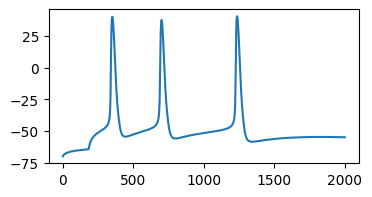

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(s.T)

TRAIN

In [20]:
from jax import jit, vmap, value_and_grad
import jaxley.optimize.transforms as jt

In [21]:
net.delete_trainables()
net.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")

params_true = net.get_parameters()


Number of newly added trainable parameters: 5. Total number of trainable parameters: 5


In [22]:
transform = jx.ParamTransform([
    {"IonotropicSynapse_gS": jt.SigmoidTransform(1e-5, 1e-2)},
])
opt_params_true = transform.inverse(params_true)

In [23]:
s = jx.integrate(net, params=params_true, t_max=10.0)


In [24]:
base_amp = i_amp # nA when bit = 1

def simulate(params, pattern):
    """
    pattern: (n_pre,) binary 0/1
    returns: soma trace (timepoints,)
    """
    # pattern scales the step amplitudes
    amps = base_amp * pattern  # (n_pre,)

    # Jaxley helper: gives one step-current trace per input dimension
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay, i_dur=i_dur,
        i_amp=amps,
        delta_t=dt, t_max=t_max
    )  # shape (n_pre, T)

    net.delete_stimuli()
    # Build data_stimuli for this pattern
    data_stimuli = None
    for i in range(n_pre):
        data_stimuli = net.cell(i).branch(0).loc(0.0).data_stimulate(
            currents[i], data_stimuli=data_stimuli
        )

    # Run network with *given* params
    traces = jx.integrate(
        net,
        params=params,
        data_stimuli=data_stimuli,
        delta_t=dt,
    )  # shape (num_recordings, T)

    # We should have recorded only the postsyn soma
    soma_trace = traces[0]  # (T,)
    return soma_trace

# Batched version over many patterns
batched_simulate = vmap(simulate, in_axes=(None, 0))  # params shared, patterns batched


In [25]:
import jax

In [26]:
key = jax.random.PRNGKey(0)
n_samples = 200   # total dataset size

patterns = jax.random.bernoulli(key, p=0.5, shape=(n_samples, n_pre))
patterns = patterns.astype(jnp.float64)

params_true = transform.forward(opt_params_true)

targets = batched_simulate(params_true, patterns)

In [27]:
split = int(0.8 * n_samples)
patterns_train = patterns[:split]
targets_train  = targets[:split]
patterns_val   = patterns[split:]
targets_val    = targets[split:]

START SANITY CHECKS FOR MY SANITY

pattern_example shape: (5,)


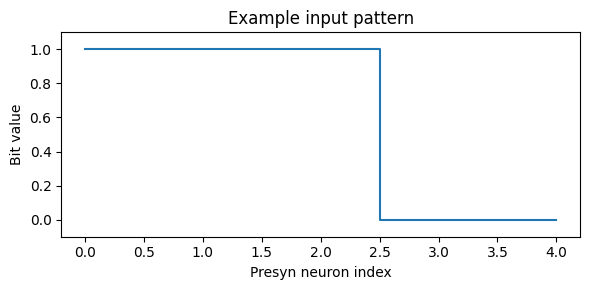

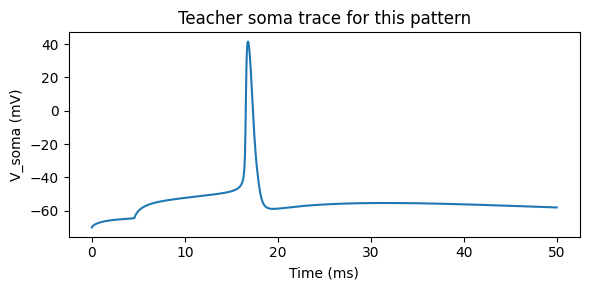

In [28]:
idx = 500
pattern_example = patterns[idx]
target_example  = targets[idx]   # shape (T,)
print("pattern_example shape:", pattern_example.shape)

# time axis from dt and T
T = target_example.shape[0]
time_vec = jnp.arange(T) * dt

plt.figure(figsize=(6, 3))
plt.step(range(n_pre), pattern_example, where="mid")
plt.ylim(-0.1, 1.1)
plt.xlabel("Presyn neuron index")
plt.ylabel("Bit value")
plt.title("Example input pattern")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(time_vec, target_example)
plt.xlabel("Time (ms)")
plt.ylabel("V_soma (mV)")
plt.title("Teacher soma trace for this pattern")
plt.tight_layout()
plt.show()


In [29]:
print("patterns.shape:", patterns.shape)
print("targets.shape:", targets.shape)

idx = 500
print("Trying idx =", idx)

pattern_example = patterns[idx]
target_example  = targets[idx]
print("pattern_example shape:", pattern_example.shape)
print("target_example shape:", target_example.shape)


patterns.shape: (200, 5)
targets.shape: (200, 2002)
Trying idx = 500
pattern_example shape: (5,)
target_example shape: (2002,)


In [30]:
print("patterns.shape:", patterns.shape)
print("targets.shape:", targets.shape)

idx = 500
print("Trying idx =", idx)

pattern_example = patterns[idx]
target_example  = targets[idx]

print("pattern_example shape:", pattern_example.shape)
print("target_example shape:", target_example.shape)
print("pattern_example:", pattern_example)


patterns.shape: (200, 5)
targets.shape: (200, 2002)
Trying idx = 500
pattern_example shape: (5,)
target_example shape: (2002,)
pattern_example: [1. 1. 1. 0. 0.]


In [31]:
print("patterns[195]:", patterns[195])
print("patterns[196]:", patterns[196])
print("patterns[197]:", patterns[197])
print("patterns[198]:", patterns[198])

patterns[195]: [0. 0. 1. 1. 0.]
patterns[196]: [1. 0. 0. 1. 1.]
patterns[197]: [1. 1. 0. 1. 0.]
patterns[198]: [1. 0. 1. 0. 1.]


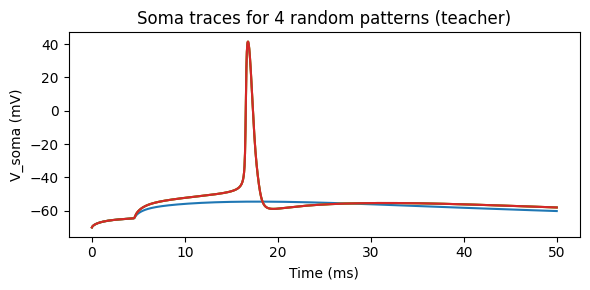

In [32]:
# run a small batch
traces = batched_simulate(params_true, patterns[195:199])  # (4, T)

T = traces.shape[1]
time_vec = jnp.arange(T) * dt

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time_vec, traces.T)   # traces.T has shape (T, 4)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("V_soma (mV)")
ax.set_title("Soma traces for 4 random patterns (teacher)")
plt.tight_layout()
plt.show()


In [33]:
traces = batched_simulate(params_true, patterns[195:199])
max_diff = jnp.max(jnp.abs(traces[0] - traces[1]))
print("max |difference| between trace 0 and 1:", float(max_diff))


max |difference| between trace 0 and 1: 96.02667276668974


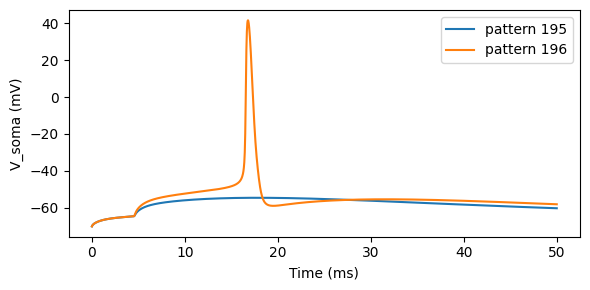

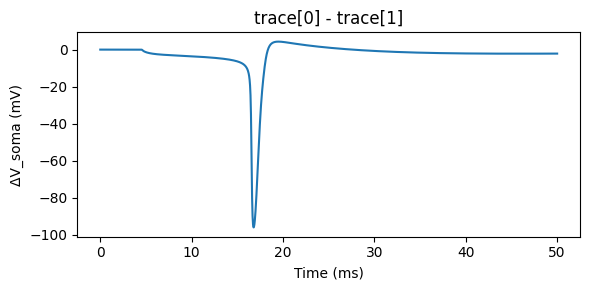

In [34]:
T = traces.shape[1]
time_vec = jnp.arange(T) * dt

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time_vec, traces[0], label="pattern 195")
ax.plot(time_vec, traces[1], label="pattern 196")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("V_soma (mV)")
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time_vec, traces[0] - traces[1])
ax.set_xlabel("Time (ms)")
ax.set_ylabel("ΔV_soma (mV)")
ax.set_title("trace[0] - trace[1]")
plt.tight_layout()
plt.show()


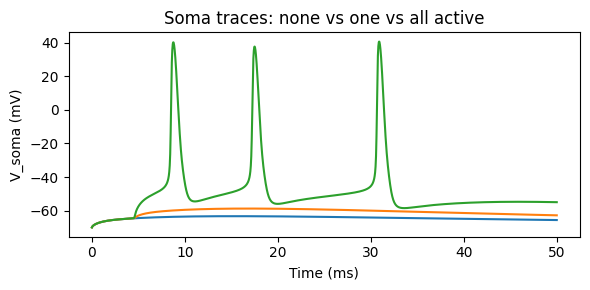

In [35]:
# Make some hand-crafted patterns
p_none = jnp.array([0, 0, 0, 0, 0.], dtype=jnp.float64)
p_one  = jnp.array([1, 0, 0, 0, 0.], dtype=jnp.float64)
p_all  = jnp.array([1, 1, 1, 1, 1.], dtype=jnp.float64)

ext_patterns = jnp.stack([p_none, p_one, p_all], axis=0)
ext_traces   = batched_simulate(params_true, ext_patterns)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time_vec, ext_traces.T)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("V_soma (mV)")
ax.set_title("Soma traces: none vs one vs all active")
plt.tight_layout()
plt.show()


SANITY DONE

TRAIN

In [36]:
# --- learner initialization (in transformed space) ---
key_learn = jax.random.PRNGKey(1)
noise_scale = 0.3  # you can tune this

def add_noise_to_opt_params(opt_params, key, scale):
    leaves, treedef = jax.tree_util.tree_flatten(opt_params)
    subkeys = jax.random.split(key, len(leaves))
    noisy_leaves = [
        p + scale * jax.random.normal(k, p.shape)
        for p, k in zip(leaves, subkeys)
    ]
    return jax.tree_util.tree_unflatten(treedef, noisy_leaves)

opt_params_learn = add_noise_to_opt_params(opt_params_true, key_learn, noise_scale)


In [37]:
def loss_fn(opt_params, patterns_batch, targets_batch):
    params = transform.forward(opt_params)
    preds = batched_simulate(params, patterns_batch)   # (B, T)
    return jnp.mean((preds - targets_batch) ** 2)

grad_fn = jit(value_and_grad(loss_fn, argnums=0))


In [38]:
import optax

learning_rate = 1e-2
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(opt_params_learn)

num_steps = 300
print_every = 20

for step in range(num_steps + 1):
    train_loss, grads = grad_fn(opt_params_learn, patterns_train, targets_train)
    updates, opt_state = optimizer.update(grads, opt_state, opt_params_learn)
    opt_params_learn = optax.apply_updates(opt_params_learn, updates)

    if step % print_every == 0:
        # validation loss (no grad, no jit needed)
        val_loss = loss_fn(opt_params_learn, patterns_val, targets_val)
        print(f"step {step:4d} | train_loss={float(train_loss):.4e} "
              f"| val_loss={float(val_loss):.4e}")


step    0 | train_loss=1.1309e+02 | val_loss=1.3541e+02
step   20 | train_loss=1.0727e+02 | val_loss=1.3467e+02
step   40 | train_loss=8.1368e+01 | val_loss=9.8032e+01
step   60 | train_loss=2.5526e+01 | val_loss=2.4516e+01
step   80 | train_loss=4.1583e+00 | val_loss=5.4777e+00
step  100 | train_loss=5.3604e-01 | val_loss=5.9695e-01
step  120 | train_loss=9.7214e-02 | val_loss=8.2825e-02
step  140 | train_loss=6.7709e-03 | val_loss=9.1870e-03
step  160 | train_loss=1.7507e-03 | val_loss=1.8069e-04
step  180 | train_loss=2.2361e-01 | val_loss=2.4342e-01
step  200 | train_loss=6.1781e-02 | val_loss=5.9473e-02
step  220 | train_loss=1.2707e-01 | val_loss=1.2500e-01
step  240 | train_loss=1.3862e-01 | val_loss=1.5068e-01
step  260 | train_loss=8.6415e-02 | val_loss=7.0350e-02
step  280 | train_loss=8.8321e-02 | val_loss=1.3154e-01
step  300 | train_loss=5.0024e-02 | val_loss=7.6656e-02


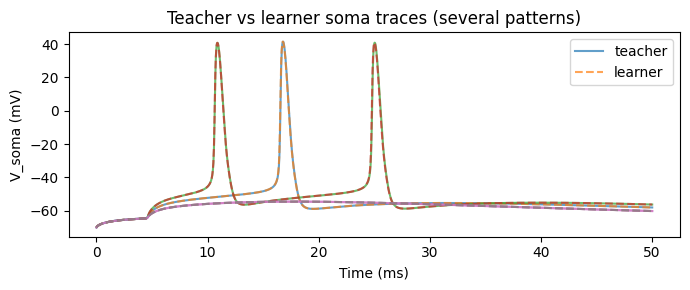

In [39]:
idxs = jnp.array([0, 1, 2, 3])  # any 4 indices < patterns_val.shape[0]

patterns_ex = patterns_val[idxs]       # (4, n_pre)
targets_ex  = targets_val[idxs]        # (4, T)


params_learn = transform.forward(opt_params_learn)


preds_ex = batched_simulate(params_learn, patterns_ex)   # (4, T)

T_ex = preds_ex.shape[1]
time_vec = jnp.arange(T_ex) * dt

plt.figure(figsize=(7, 3))
for i in range(len(idxs)):
    plt.plot(time_vec, targets_ex[i],       alpha=0.7, label="teacher" if i == 0 else None)
    plt.plot(time_vec, preds_ex[i], "--",   alpha=0.7, label="learner" if i == 0 else None)

plt.xlabel("Time (ms)")
plt.ylabel("V_soma (mV)")
plt.title("Teacher vs learner soma traces (several patterns)")
plt.legend()
plt.tight_layout()
plt.show()


GRADIENTS!

In [40]:
params_learn_phys = transform.forward(opt_params_learn)

In [41]:
def simulate(params_phys, pattern):
    amps = base_amp * pattern
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay, i_dur=i_dur,
        i_amp=amps, delta_t=dt, t_max=t_max
    )
    data_stimuli = None
    for i in range(n_pre):
        data_stimuli = net.cell(i).branch(0).loc(0.0).data_stimulate(
            currents[i], data_stimuli=data_stimuli
        )

    traces = jx.integrate(
        net,
        params=params_phys,
        data_stimuli=data_stimuli,
        delta_t=dt,
    )
    soma_trace = traces[0]
    return soma_trace


In [42]:
def single_loss_phys(params_phys, pattern, target_trace):
    pred = simulate(params_phys, pattern)   # uses params_phys directly now
    return jnp.mean((pred - target_trace) ** 2)


In [43]:
idx = 0 
pattern_ex = patterns_val[idx]
target_ex  = targets_val[idx]    

loss_val, grads_phys = value_and_grad(single_loss_phys)(
    params_learn_phys, pattern_ex, target_ex
)

print("single-example loss:", float(loss_val))

# gradient wrt synaptic conductances
gS_grad = grads_phys[0]["IonotropicSynapse_gS"]   # ndarray
print("gS_grad shape:", gS_grad.shape)
print("gS_grad (first few):", gS_grad[:10])

gS_learn = params_learn_phys[0]["IonotropicSynapse_gS"]
print("gS_learn shape:", gS_learn.shape)
print("gS_learn (first few):", gS_learn[:10])


single-example loss: 0.10635747366530358
gS_grad shape: (5,)
gS_grad (first few): [2422661.87886408 2422661.87886408  510295.24521583 2422661.87886408
  510295.24521583]
gS_learn shape: (5,)
gS_learn (first few): [0.00010002 0.00010003 0.00010002 0.00010003 0.00010003]


DEFINE BIOPHYSICAL CORRELATES TO LOOK AT